<a href="https://colab.research.google.com/github/7201krap/PYTORCH_project/blob/main/sparsity_adadelta_weight_decay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [ ]:
torch.manual_seed(1234)
np.random.seed(1234)

In [ ]:
mnist_trainset = datasets.MNIST(root='./data', train=True, 
                                download=True, 
                                transform=transforms.Compose([transforms.ToTensor()]))

mnist_testset  = datasets.MNIST(root='./data', 
                                train=False, 
                                download=True, 
                                transform=transforms.Compose([transforms.ToTensor()]))

train_dataloader = torch.utils.data.DataLoader(mnist_trainset, 
                                               batch_size=50, 
                                               shuffle=True)

test_dataloader  = torch.utils.data.DataLoader(mnist_testset, 
                                               batch_size=50, 
                                               shuffle=False)

print("Training dataset size: ", len(mnist_trainset))
print("Testing dataset size: ",  len(mnist_testset))

Training dataset size:  60000
Testing dataset size:  10000


In [ ]:
# Define the model 
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear_1 = torch.nn.Linear(784, 256)
        self.linear_2 = torch.nn.Linear(256, 10)
        self.sigmoid  = torch.nn.Sigmoid()

    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.sigmoid(x)
        pred = self.linear_2(x)

        return pred

In [ ]:
def get_activation(model):    
    def hook(module, input, output):
        model.layer_activations = output
    return hook

In [ ]:
no_epochs = 30
criterion = torch.nn.CrossEntropyLoss()
def sparsity_trainer(optimizer, model):

    # reset the model 
    train_loss = list()
    test_loss  = list()
    test_acc   = list()
    final_spareness = list()

    # define activation list 

    best_test_loss = 1

    for epoch in range(no_epochs):
        total_train_loss = 0
        total_test_loss = 0

        hidden_layer_activation_list = list()

        # training
        # set up training mode 
        model.train()
        for itr, (image, label) in enumerate(train_dataloader):
            optimizer.zero_grad()

            pred = model(image)

            loss = criterion(pred, label)
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()

        total_train_loss = total_train_loss / (itr + 1)
        train_loss.append(total_train_loss)

        # testing 
        # change to evaluation mode 
        model.eval()
        total = 0
        for itr, (image, label) in enumerate(test_dataloader):

            pred = model(image)

            loss = criterion(pred, label)
            total_test_loss += loss.item()

            # we now need softmax because we are testing.
            pred = torch.nn.functional.softmax(pred, dim=1)
            for i, p in enumerate(pred):
                if label[i] == torch.max(p.data, 0)[1]:
                    total = total + 1

            hidden_layer_activation_list.append(model.layer_activations)

        # this conains activations for all epochs 
        final_spareness.append(hidden_layer_activation_list)

        # caculate accuracy 
        accuracy = total / len(mnist_testset)

        # append accuracy here
        test_acc.append(accuracy)

        # append test loss here 
        total_test_loss = total_test_loss / (itr + 1)
        test_loss.append(total_test_loss)

        # print('\nEpoch: {}/{}, Train Loss: {:.8f}, Test Loss: {:.8f}, Test Accuracy: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_test_loss, accuracy))

        # if total_test_loss < best_test_loss:
        #     best_test_loss = total_test_loss
            # print("Saving the model state dictionary for Epoch: {} with Test loss: {:.8f}".format(epoch + 1, total_test_loss))
            # torch.save(model.state_dict(), "model.dth")

    sparseness_list = list()

    for single_epoch_spareness in final_spareness:
        single_epoch_spareness = torch.stack(single_epoch_spareness)
        layer_activations_list = torch.reshape(single_epoch_spareness, (10000, 256))

        layer_activations_list = torch.abs(layer_activations_list)  # modified 
        num_neurons = layer_activations_list.shape[1]
        population_sparseness = (np.sqrt(num_neurons) - (torch.sum(layer_activations_list, dim=1) / torch.sqrt(torch.sum(layer_activations_list ** 2, dim=1)))) / (np.sqrt(num_neurons) - 1)
        mean_sparseness_per_epoch = torch.mean(population_sparseness)

        sparseness_list.append(mean_sparseness_per_epoch)

    return test_acc, sparseness_list

In [ ]:
weight_decay = [0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
f = open("test_weight_decay.txt", "a")
for i in range(10):
    print(f"Entering {i}-th loop")
    model_adadelta_weight_decay = Model()
    model_adadelta_weight_decay.sigmoid.register_forward_hook(get_activation(model_adadelta_weight_decay))
    optimizer_adadelta = torch.optim.Adadelta(model_adadelta_weight_decay.parameters(), lr=1, weight_decay=weight_decay[i])

    adadelta_test_acc, adadelta_sparseness_list = sparsity_trainer(optimizer=optimizer_adadelta, model=model_adadelta_weight_decay)
    f.write(str(adadelta_test_acc)+','+str(adadelta_sparseness_list)+'\n')
f.close()

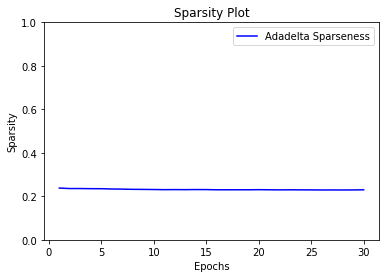

In [ ]:
fig=plt.figure(figsize=(20, 10))
plt.plot(np.arange(1, no_epochs+1), adadelta_sparseness_lists[0],  label="weight decay: 0.0")
plt.plot(np.arange(1, no_epochs+1), adadelta_sparseness_lists[1],  label="weight decay: 10.0")
plt.plot(np.arange(1, no_epochs+1), adadelta_sparseness_lists[2],  label="weight decay: 20.0")
plt.plot(np.arange(1, no_epochs+1), adadelta_sparseness_lists[3],  label="weight decay: 30.0")
plt.plot(np.arange(1, no_epochs+1), adadelta_sparseness_lists[4],  label="weight decay: 40.0")
plt.plot(np.arange(1, no_epochs+1), adadelta_sparseness_lists[5],  label="weight decay: 50.0")
plt.plot(np.arange(1, no_epochs+1), adadelta_sparseness_lists[6],  label="weight decay: 60.0")
plt.plot(np.arange(1, no_epochs+1), adadelta_sparseness_lists[7],  label="weight decay: 70.0")
plt.plot(np.arange(1, no_epochs+1), adadelta_sparseness_lists[8],  label="weight decay: 80.0")
plt.plot(np.arange(1, no_epochs+1), adadelta_sparseness_lists[9],  label="weight decay: 90.0")
plt.plot(np.arange(1, no_epochs+1), adadelta_sparseness_lists[10], label="weight decay: 100.0")
plt.xlabel('Epochs')
plt.ylabel('Sparsity')
plt.ylim(0, 1)
plt.title("Sparsity Plot")
plt.legend(loc='best')
plt.show()

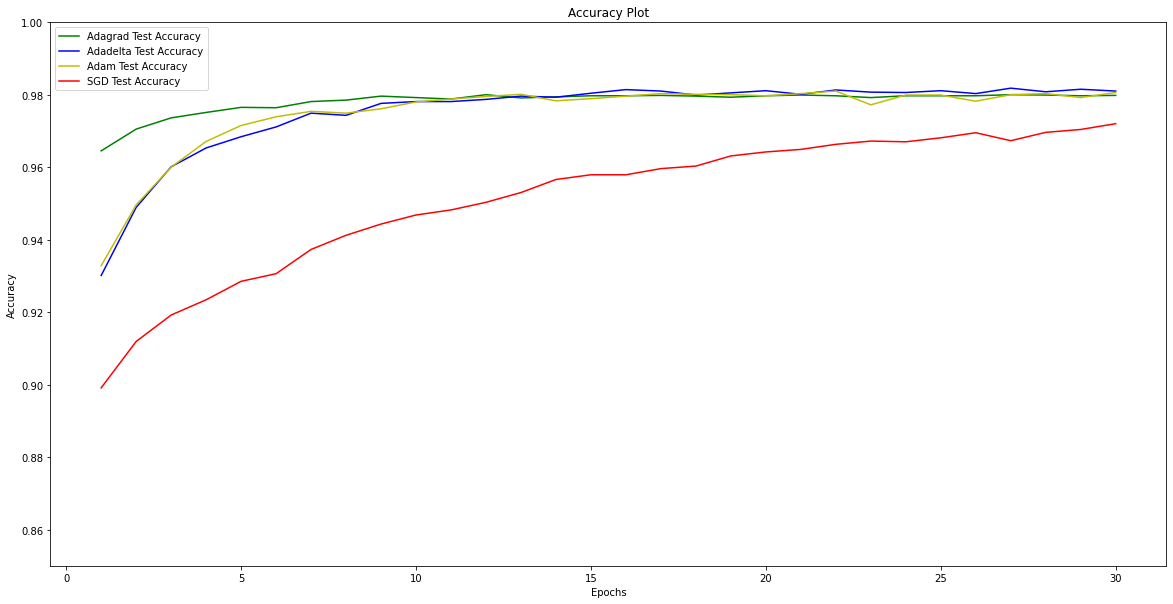

In [ ]:
fig=plt.figure(figsize=(20, 10))
plt.plot(np.arange(1, no_epochs+1), adadelta_test_accs[0],  label="Adadelta Test Accuracy: weight_decay  = 0")
plt.plot(np.arange(1, no_epochs+1), adadelta_test_accs[1],  label="Adadelta Test Accuracy: weight_decay  = 10")
plt.plot(np.arange(1, no_epochs+1), adadelta_test_accs[2],  label="Adadelta Test Accuracy: weight_decay  = 20")
plt.plot(np.arange(1, no_epochs+1), adadelta_test_accs[3],  label="Adadelta Test Accuracy: weight_decay  = 30")
plt.plot(np.arange(1, no_epochs+1), adadelta_test_accs[4],  label="Adadelta Test Accuracy: weight_decay  = 40")
plt.plot(np.arange(1, no_epochs+1), adadelta_test_accs[5],  label="Adadelta Test Accuracy: weight_decay  = 50")
plt.plot(np.arange(1, no_epochs+1), adadelta_test_accs[6],  label="Adadelta Test Accuracy: weight_decay  = 60")
plt.plot(np.arange(1, no_epochs+1), adadelta_test_accs[7],  label="Adadelta Test Accuracy: weight_decay  = 70")
plt.plot(np.arange(1, no_epochs+1), adadelta_test_accs[8],  label="Adadelta Test Accuracy: weight_decay  = 80")
plt.plot(np.arange(1, no_epochs+1), adadelta_test_accs[9],  label="Adadelta Test Accuracy: weight_decay  = 90")
plt.plot(np.arange(1, no_epochs+1), adadelta_test_accs[10], label="Adadelta Test Accuracy: weight_decay = 100")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.85, 1)
plt.title("Accuracy Plot")
plt.legend(loc='best')
plt.show()